<a href="https://colab.research.google.com/github/palashbaranwal/MNIST_BatchNorm_Regularization/blob/master/Assignment_6_L1_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [9]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

print(1+10)


11


# Dataset and Creating Train/Test Split

In [11]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)
print(9+46)

55


# Dataloader Arguments & Test/Train Dataloaders


In [12]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


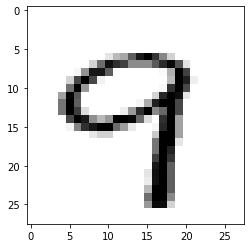

In [13]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

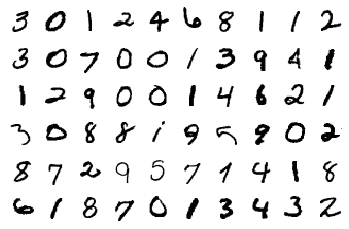

In [14]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        # self.convblock4 = nn.Sequential(
        #     nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
            
        #     nn.ReLU()
        # ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        #     nn.BatchNorm2d(10),
        #     nn.ReLU()
        # ) # output_size = 7
         
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 5

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 3

        # self.convblock9 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        # ) # output_size = 5

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1



        # self.convblock8 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
        #     # nn.BatchNorm2d(10), NEVER
        #     # nn.ReLU() NEVER!
        # ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        #x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        #x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        #x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [16]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))
print("Check {0}",str("1+2"))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 10, 22, 22]             900
       BatchNorm2d-8           [-1, 10, 22, 22]              20
              ReLU-9           [-1, 10, 22, 22]               0
        MaxPool2d-10           [-1, 10, 11, 11]               0
           Conv2d-11             [-1, 10, 9, 9]             900
      BatchNorm2d-12             [-1, 10, 9, 9]              20
             ReLU-13             [-1, 10, 9, 9]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  criterion = nn.CrossEntropyLoss().to(device)
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    reg_loss = 0 
    #l1_crit = nn.L1Loss(size_average=False)
    for param in model.parameters():
      #if param.dim()>1:
      reg_loss +=  torch.sum(abs(param))
        #reg_loss +=  param.norm(1)
        #reg_loss+=l1_crit(param)
    classify_loss = criterion(y_pred,target)

    factor = 0.0005
    loss = classify_loss + factor * reg_loss
    #loss += factor * reg_loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [18]:
from torch.optim.lr_scheduler import StepLR
import datetime

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    print(datetime.datetime.now())
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0
2020-03-08 13:21:04.314276


Loss=0.32614031434059143 Batch_id=468 Accuracy=93.55: 100%|██████████| 469/469 [00:12<00:00, 38.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1008, Accuracy: 9820/10000 (98.20%)

EPOCH: 1
2020-03-08 13:21:18.091120


Loss=0.32205671072006226 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:12<00:00, 38.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0710, Accuracy: 9865/10000 (98.65%)

EPOCH: 2
2020-03-08 13:21:31.919732


Loss=0.17925730347633362 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:12<00:00, 37.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1391, Accuracy: 9608/10000 (96.08%)

EPOCH: 3
2020-03-08 13:21:45.990544


Loss=0.19955535233020782 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:12<00:00, 45.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0912, Accuracy: 9757/10000 (97.57%)

EPOCH: 4
2020-03-08 13:21:59.971523


Loss=0.18677450716495514 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:12<00:00, 37.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0544, Accuracy: 9843/10000 (98.43%)

EPOCH: 5
2020-03-08 13:22:13.921138


Loss=0.2036183476448059 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:12<00:00, 38.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0734, Accuracy: 9791/10000 (97.91%)

EPOCH: 6
2020-03-08 13:22:27.767431


Loss=0.1907157599925995 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:12<00:00, 37.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0657, Accuracy: 9830/10000 (98.30%)

EPOCH: 7
2020-03-08 13:22:41.740403


Loss=0.21135717630386353 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:12<00:00, 38.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9856/10000 (98.56%)

EPOCH: 8
2020-03-08 13:22:55.520253


Loss=0.2522208094596863 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:12<00:00, 44.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0598, Accuracy: 9843/10000 (98.43%)

EPOCH: 9
2020-03-08 13:23:09.509832


Loss=0.15984512865543365 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:12<00:00, 37.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0635, Accuracy: 9818/10000 (98.18%)

EPOCH: 10
2020-03-08 13:23:23.446050


Loss=0.15989860892295837 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:12<00:00, 37.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0515, Accuracy: 9851/10000 (98.51%)

EPOCH: 11
2020-03-08 13:23:37.605526


Loss=0.20627695322036743 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:12<00:00, 38.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9892/10000 (98.92%)

EPOCH: 12
2020-03-08 13:23:51.514128


Loss=0.1798745095729828 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:12<00:00, 37.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 9882/10000 (98.82%)

EPOCH: 13
2020-03-08 13:24:05.573150


Loss=0.15599218010902405 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:12<00:00, 37.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0663, Accuracy: 9810/10000 (98.10%)

EPOCH: 14
2020-03-08 13:24:19.534840


Loss=0.16071629524230957 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:12<00:00, 38.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0481, Accuracy: 9868/10000 (98.68%)

EPOCH: 15
2020-03-08 13:24:33.339012


Loss=0.1655237376689911 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:12<00:00, 38.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9896/10000 (98.96%)

EPOCH: 16
2020-03-08 13:24:47.108799


Loss=0.24361670017242432 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:12<00:00, 38.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0660, Accuracy: 9806/10000 (98.06%)

EPOCH: 17
2020-03-08 13:25:00.926345


Loss=0.27608123421669006 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:12<00:00, 38.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0673, Accuracy: 9813/10000 (98.13%)

EPOCH: 18
2020-03-08 13:25:14.835883


Loss=0.15959246456623077 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:12<00:00, 38.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0493, Accuracy: 9865/10000 (98.65%)

EPOCH: 19
2020-03-08 13:25:28.736224


Loss=0.19649121165275574 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:12<00:00, 38.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9861/10000 (98.61%)

EPOCH: 20
2020-03-08 13:25:42.605301


Loss=0.13138915598392487 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:12<00:00, 38.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9859/10000 (98.59%)

EPOCH: 21
2020-03-08 13:25:56.406751


Loss=0.15506121516227722 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:12<00:00, 38.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0727, Accuracy: 9790/10000 (97.90%)

EPOCH: 22
2020-03-08 13:26:10.260001


Loss=0.17174430191516876 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:12<00:00, 37.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9874/10000 (98.74%)

EPOCH: 23
2020-03-08 13:26:24.252328


Loss=0.142442524433136 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:12<00:00, 37.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0738, Accuracy: 9796/10000 (97.96%)

EPOCH: 24
2020-03-08 13:26:38.274217


Loss=0.15359431505203247 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:12<00:00, 37.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0532, Accuracy: 9847/10000 (98.47%)

EPOCH: 25
2020-03-08 13:26:52.337559


Loss=0.22051440179347992 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:12<00:00, 37.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9883/10000 (98.83%)

EPOCH: 26
2020-03-08 13:27:06.321622


Loss=0.12703239917755127 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:12<00:00, 38.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0560, Accuracy: 9842/10000 (98.42%)

EPOCH: 27
2020-03-08 13:27:20.231316


Loss=0.14453989267349243 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:12<00:00, 38.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9886/10000 (98.86%)

EPOCH: 28
2020-03-08 13:27:34.187655


Loss=0.22510692477226257 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:12<00:00, 38.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9875/10000 (98.75%)

EPOCH: 29
2020-03-08 13:27:48.063157


Loss=0.14381097257137299 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:12<00:00, 37.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9908/10000 (99.08%)

EPOCH: 30
2020-03-08 13:28:02.083617


Loss=0.16957855224609375 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:12<00:00, 38.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0562, Accuracy: 9830/10000 (98.30%)

EPOCH: 31
2020-03-08 13:28:15.831224


Loss=0.12771281599998474 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:12<00:00, 38.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0362, Accuracy: 9897/10000 (98.97%)

EPOCH: 32
2020-03-08 13:28:29.581318


Loss=0.22437354922294617 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:12<00:00, 38.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9866/10000 (98.66%)

EPOCH: 33
2020-03-08 13:28:43.301535


Loss=0.14733730256557465 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:12<00:00, 38.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9893/10000 (98.93%)

EPOCH: 34
2020-03-08 13:28:57.009133


Loss=0.19158276915550232 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:12<00:00, 38.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9851/10000 (98.51%)

EPOCH: 35
2020-03-08 13:29:10.864704


Loss=0.17661823332309723 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:12<00:00, 37.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9888/10000 (98.88%)

EPOCH: 36
2020-03-08 13:29:24.914331


Loss=0.1553775817155838 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:12<00:00, 38.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9886/10000 (98.86%)

EPOCH: 37
2020-03-08 13:29:38.898280


Loss=0.17702838778495789 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:12<00:00, 37.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0501, Accuracy: 9846/10000 (98.46%)

EPOCH: 38
2020-03-08 13:29:52.951303


Loss=0.23166926205158234 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:12<00:00, 38.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9882/10000 (98.82%)

EPOCH: 39
2020-03-08 13:30:06.885994


Loss=0.1379052698612213 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:12<00:00, 38.23it/s]



Test set: Average loss: 0.0556, Accuracy: 9847/10000 (98.47%)



Text(0.5, 1.0, 'Test Accuracy')

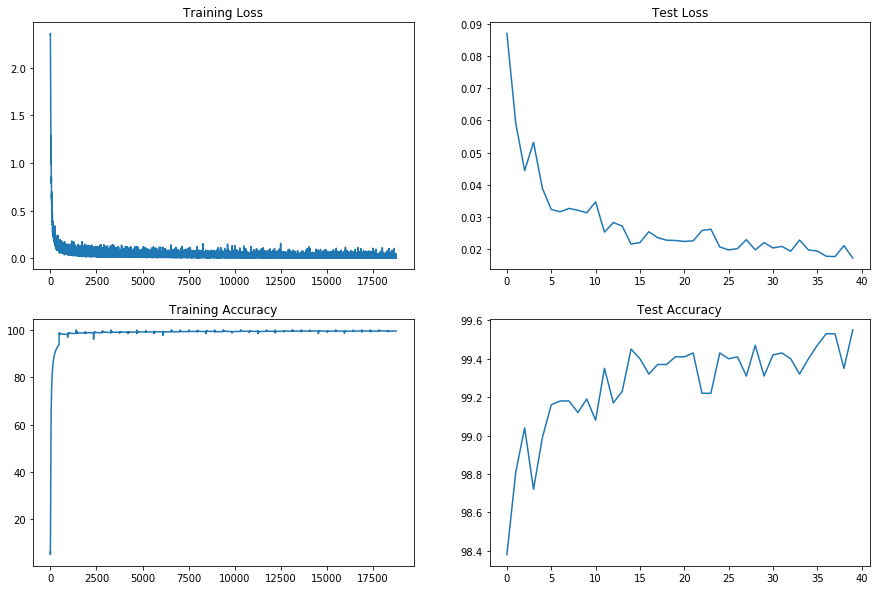

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")